In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sentence_transformers import SentenceTransformer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
import optuna
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator
from mlxtend.classifier import StackingClassifier

In [ ]:
data = pd.read_csv('/content/data/comms_f1.csv')

In [ ]:
data.head()

,Unnamed: 0,User1 ID,User2 ID,Message,Label,Peerness,Age_User1,Gender_User1,Grade_User1,Age_User2,Gender_User2,Grade_User2
0,0,1,2,bye bye dear bajaj i got some better work to ...,1,0.5,11,Others,5.0,15.0,Male,9.0
1,1,1,2,Haha your so funny you sit on wikipedia all da...,1,0.5,11,Others,5.0,15.0,Male,9.0
2,2,1,2,My problem is people talking out of their asse...,1,0.5,11,Others,5.0,15.0,Male,9.0
3,3,1,2,Article updated,0,0.5,11,Others,5.0,15.0,Male,9.0
4,4,1,2,Well arent you phucking special Its easy to ha...,1,0.5,11,Others,5.0,15.0,Male,9.0


In [ ]:
# Drop unnecessary columns (e.g., 'Unnamed: 0')
data = data.drop(columns=['Unnamed: 0'], errors='ignore')

In [ ]:
#checking null values
data.isnull().sum()

,0
User1 ID,0
User2 ID,0
Message,0
Label,0
Peerness,2579
Age_User1,0
Gender_User1,0
Grade_User1,1
Age_User2,1
Gender_User2,1


In [ ]:
#filling the null values
# KNN Imputation for 'Peerness'
# Custom wrapper for XGBClassifier
class SklearnCompatibleXGBClassifier(XGBClassifier, BaseEstimator):
    pass

imputer_knn = KNNImputer(n_neighbors=5)
data['Peerness'] = imputer_knn.fit_transform(data[['Peerness', 'Age_User1', 'Grade_User1', 'Age_User2', 'Grade_User2']])[:, 0]

# Linear Interpolation for Demographic Features
data['Age_User1'] = data['Age_User1'].interpolate(method='linear')
data['Grade_User1'] = data['Grade_User1'].interpolate(method='linear')
data['Age_User2'] = data['Age_User2'].interpolate(method='linear')
data['Grade_User2'] = data['Grade_User2'].interpolate(method='linear')

# For Gender columns, fill missing with the most frequent value (mode)
data['Gender_User1'] = data['Gender_User1'].fillna(data['Gender_User1'].mode()[0])
data['Gender_User2'] = data['Gender_User2'].fillna(data['Gender_User2'].mode()[0])
data['Label'] = data['Label'].fillna(data['Label'].mode()[0])

In [ ]:
#checking null values again
data.isnull().sum()

,0
User1 ID,0
User2 ID,0
Message,0
Label,0
Peerness,0
Age_User1,0
Gender_User1,0
Grade_User1,0
Age_User2,0
Gender_User2,0


In [ ]:
# Encode categorical data (e.g., gender)
label_encoder = LabelEncoder()
data['Gender_User1'] = label_encoder.fit_transform(data['Gender_User1'])
data['Gender_User2'] = label_encoder.fit_transform(data['Gender_User2'])

In [ ]:
#checking data before vectorization
data.head()

,User1 ID,User2 ID,Message,Label,Peerness,Age_User1,Gender_User1,Grade_User1,Age_User2,Gender_User2,Grade_User2
0,1,2,bye bye dear bajaj i got some better work to ...,1,0.5,11,3,5.0,15.0,1,9.0
1,1,2,Haha your so funny you sit on wikipedia all da...,1,0.5,11,3,5.0,15.0,1,9.0
2,1,2,My problem is people talking out of their asse...,1,0.5,11,3,5.0,15.0,1,9.0
3,1,2,Article updated,0,0.5,11,3,5.0,15.0,1,9.0
4,1,2,Well arent you phucking special Its easy to ha...,1,0.5,11,3,5.0,15.0,1,9.0


In [ ]:
#Prepare the features (X) and target (y)
X_text = data['Message']
X_other = data[['Peerness', 'Age_User1', 'Gender_User1', 'Grade_User1', 'Age_User2', 'Gender_User2', 'Grade_User2']]
y = data['Label']

# Load a more advanced Sentence Transformer model
model = SentenceTransformer('all-mpnet-base-v2')

# Generate embeddings using Sentence Transformers
X_bert = model.encode(X_text.tolist(), batch_size=32, show_progress_bar=True)

# Combine Sentence Transformer embeddings with other features
X_other = X_other.values  # Already in NumPy
X = np.concatenate((X_bert, X_other), axis=1)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/969 [00:00<?, ?it/s]

Batches:   0%|          | 0/969 [00:00<?, ?it/s]

Accuracy: 0.8250766499919315
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.87      0.84      3384
           1       0.83      0.77      0.80      2813

    accuracy                           0.83      6197
   macro avg       0.83      0.82      0.82      6197
weighted avg       0.83      0.83      0.82      6197



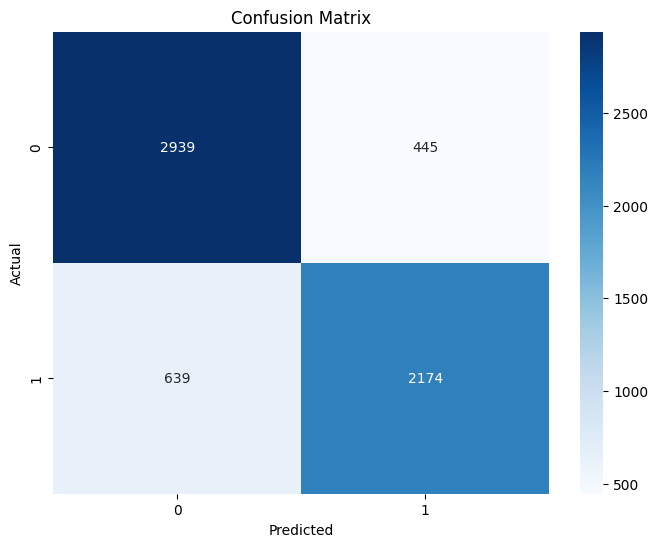

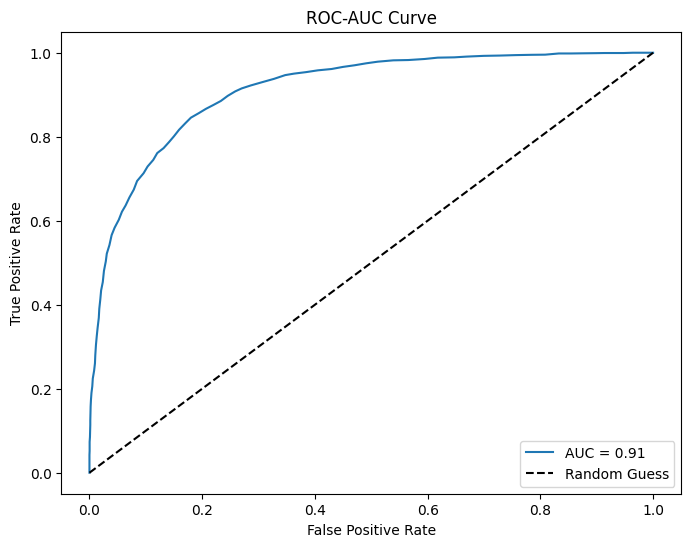

Model training and evaluation complete.


In [ ]:
data['Gender_User1'] = label_encoder.fit_transform(data['Gender_User1'])
data['Gender_User2'] = label_encoder.fit_transform(data['Gender_User2'])

# Prepare the features (X) and target (y)
X_text = data['Message']
X_other = data[['Peerness', 'Age_User1', 'Gender_User1', 'Grade_User1', 'Age_User2', 'Gender_User2', 'Grade_User2']]
y = data['Label']

# Load a Sentence Transformer model
model = SentenceTransformer('all-mpnet-base-v2')

# Generate embeddings using Sentence Transformers
X_bert = model.encode(X_text.tolist(), batch_size=32, show_progress_bar=True)

# Combine Sentence Transformer embeddings with other features
X_other = torch.tensor(X_other.values, dtype=torch.float32).numpy()
X = torch.cat((torch.tensor(X_bert, dtype=torch.float32), torch.tensor(X_other, dtype=torch.float32)), dim=1).numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC Curve
if len(set(y)) == 2:  # Ensure binary classification
    y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title('ROC-AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

print("Model training and evaluation complete.")


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:06:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:06:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:06:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [09:06:14] WARNING: /workspace/src/common/error_ms

Accuracy: 0.8406906372374511
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.86      0.85      3049
           1       0.83      0.82      0.82      2569

    accuracy                           0.84      5618
   macro avg       0.84      0.84      0.84      5618
weighted avg       0.84      0.84      0.84      5618



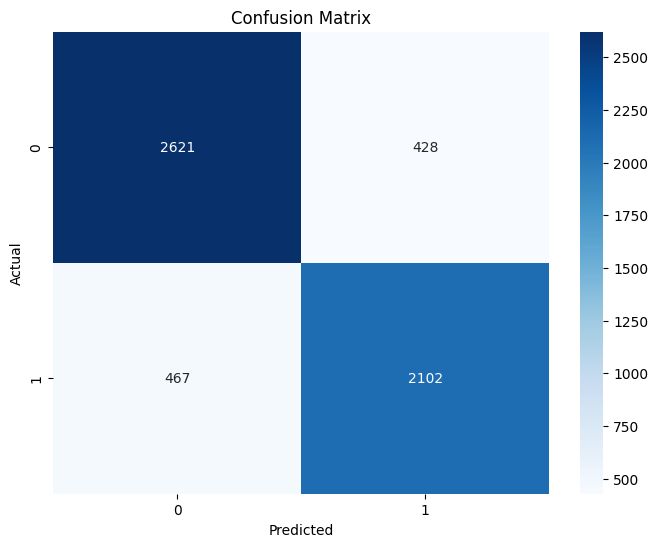

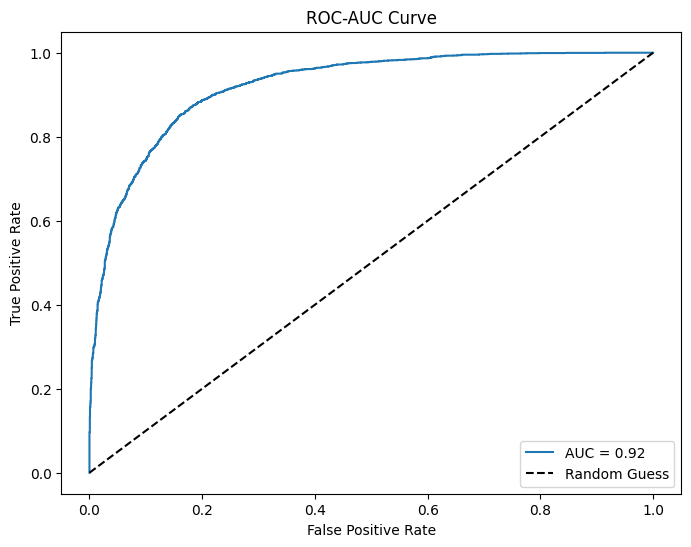

Model training and evaluation complete.


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
xgb_classifier = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', random_state=42)
xgb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC Curve
if len(set(y)) == 2:  # Ensure binary classification
    y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title('ROC-AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

print("Model training and evaluation complete.")


[I 2024-12-20 10:42:33,876] A new study created in memory with name: no-name-ca099642-81f8-4875-bda8-5851714c0465
[I 2024-12-20 10:43:21,501] Trial 0 finished with value: 0.8476682265612393 and parameters: {'n_estimators': 204, 'max_depth': 15, 'learning_rate': 0.0839399229703021, 'subsample': 0.970350675659196, 'colsample_bytree': 0.9421368086559707}. Best is trial 0 with value: 0.8476682265612393.
[I 2024-12-20 10:44:07,727] Trial 1 finished with value: 0.8394384379538486 and parameters: {'n_estimators': 125, 'max_depth': 13, 'learning_rate': 0.045443266635763424, 'subsample': 0.8737981122102515, 'colsample_bytree': 0.9410618149315417}. Best is trial 0 with value: 0.8476682265612393.
[I 2024-12-20 10:44:48,280] Trial 2 finished with value: 0.8460545425205744 and parameters: {'n_estimators': 283, 'max_depth': 13, 'learning_rate': 0.10082328584031798, 'subsample': 0.9428996359649049, 'colsample_bytree': 0.8296724964432257}. Best is trial 0 with value: 0.8476682265612393.
[I 2024-12-20 

Best Parameters: {'n_estimators': 239, 'max_depth': 10, 'learning_rate': 0.11508232286701552, 'subsample': 0.8452122810294072, 'colsample_bytree': 0.9949017035764091}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:52:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:52:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:53:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Accuracy: 0.850895594642569
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      3384
           1       0.84      0.83      0.83      2813

    accuracy                           0.85      6197
   macro avg       0.85      0.85      0.85      6197
weighted avg       0.85      0.85      0.85      6197



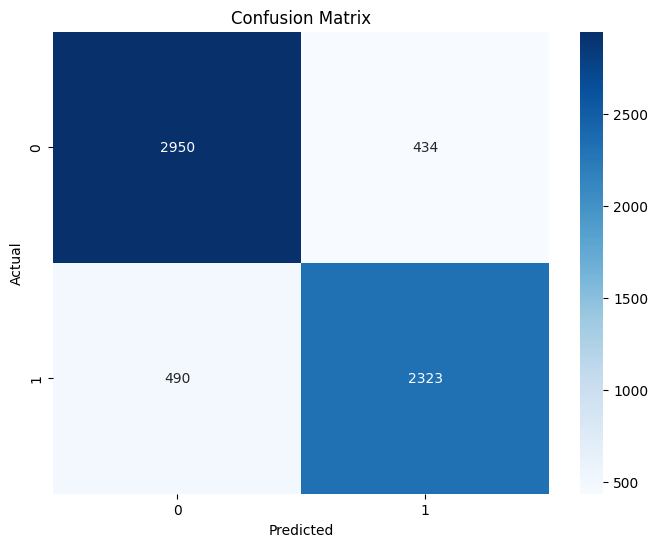

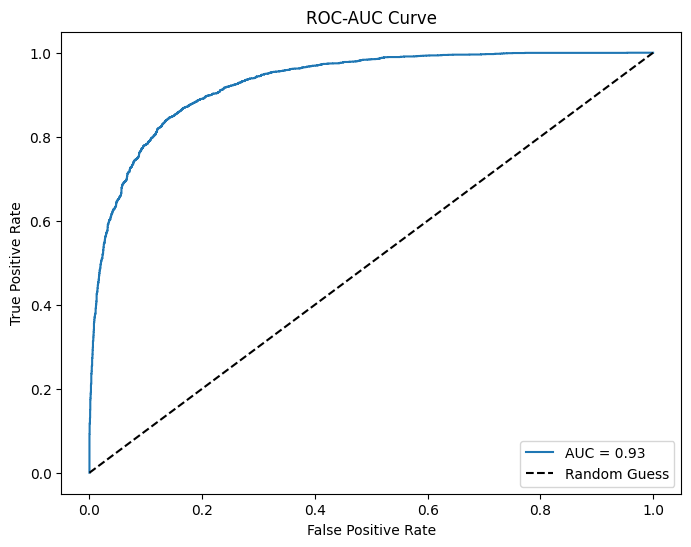

Model training and evaluation complete.


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna optimization
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 6, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.8, 1.0),
       'tree_method': 'hist',
    'device': 'cuda',
        'random_state': 42
    }
    model = XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

# Get best parameters
best_params = study.best_params
print("Best Parameters:", best_params)

# Train the best model
best_model = XGBClassifier(**best_params, tree_method='gpu_hist', predictor='gpu_predictor', random_state=42)
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ROC-AUC Curve
if len(set(y)) == 2:  # Ensure binary classification
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title('ROC-AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

print("Model training and evaluation complete.")


In [ ]:
import pickle

# Save the trained model to a pickle file
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print("Model has been saved as 'best_model.pkl'.")

Model has been saved as 'best_model.pkl'.
